In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
#loading microstructures and masks
path = 'C:\\Users\\kevin\\Desktop\\CMS\\Steel Image\\train_val\\'
inputs = []
masks=[]
val_images = []
val_masks = []
for image in os.listdir(path+'images'): #train images
    img = cv2.imread(path+'images\\'+image, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256,256))
    inputs.append(img)
    
inputs = np.array(inputs)
inputs = inputs/255
inputs = np.expand_dims(inputs, axis=-1)

for image in os.listdir(path+'masks'):# train masks
    img = cv2.imread(path+'masks\\'+image, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256,256))
    masks.append(img)
    
masks = np.array(masks)
masks = masks/255
masks = np.expand_dims(masks, axis=-1)

for image in os.listdir(path+'val_images'): #validation images
    img = cv2.imread(path+'val_images\\'+image, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256,256))
    val_images.append(img)
    
val_images = np.array(val_images)  
val_images = val_images/255
val_images = np.expand_dims(val_images, axis=-1)

for image in os.listdir(path+'val_masks'): #validation masks
    img = cv2.imread(path+'val_masks\\'+image, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256,256))
    val_masks.append(img)
    
val_masks = np.array(val_masks)  
val_masks = val_masks/255
val_masks = np.expand_dims(val_masks, axis=-1)

In [3]:
#normalizing data
masks.shape

(12, 256, 256, 1)

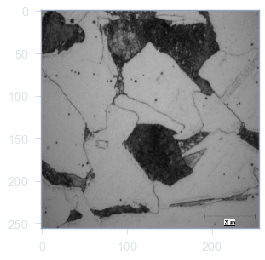

In [4]:
plt.imshow(np.squeeze(inputs[0]), cmap = 'gray')

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D
from tensorflow.keras.optimizers import SGD

In [6]:
def down_block(x, filters, kernel_size=(2,2), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(2,2), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(2,2), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [7]:
def UNet():
    f = [16, 32, 64, 128, 256, 512, 1024, 2048]
    inputs = keras.layers.Input((256, 256, 1))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) 
    c2, p2 = down_block(p1, f[1]) 
    c3, p3 = down_block(p2, f[2]) 
    c4, p4 = down_block(p3, f[3]) 
    c5, p5 = down_block(p4, f[4])
    
    bn = bottleneck(p5, f[5])
    
    u1 = up_block(bn, c5, f[4]) 
    u2 = up_block(u1, c4, f[3]) 
    u3 = up_block(u2, c3, f[2]) 
    u4 = up_block(u3, c2, f[1]) 
    u5 = up_block(u4, c1, f[0]) 

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u5)
    model = keras.models.Model(inputs, outputs)
    return model

In [8]:
model = UNet()
model.compile(optimizer='adam', loss="poisson")
#model.summary()

In [9]:
log_directory = 'logs\\fit'

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
early_stop = EarlyStopping(monitor='val_loss',patience=100)
board = TensorBoard(log_dir=log_directory,histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=1)

In [11]:
model.fit(inputs, masks, epochs=1000, validation_data = (val_images, val_masks), callbacks = [early_stop])

Train on 12 samples, validate on 12 samples
Epoch 1/1000
12/12 [==============================] - 8s 657ms/sample - loss: 1.0529 - val_loss: 0.9279
Epoch 2/1000
12/12 [==============================] - 0s 34ms/sample - loss: 1.0464 - val_loss: 0.9251
Epoch 3/1000
12/12 [==============================] - 0s 35ms/sample - loss: 1.0416 - val_loss: 0.9225
Epoch 4/1000
12/12 [==============================] - 0s 34ms/sample - loss: 1.0367 - val_loss: 0.9192
Epoch 5/1000
12/12 [==============================] - 0s 35ms/sample - loss: 1.0303 - val_loss: 0.9148
Epoch 6/1000
12/12 [==============================] - 0s 35ms/sample - loss: 1.0205 - val_loss: 0.9119
Epoch 7/1000
12/12 [==============================] - 0s 35ms/sample - loss: 1.0036 - val_loss: 0.9462
Epoch 8/1000
12/12 [==============================] - 0s 34ms/sample - loss: 0.9953 - val_loss: 0.9541
Epoch 9/1000
12/12 [==============================] - 0s 34ms/sample - loss: 0.9950 - val_loss: 0.9331
Epoch 10/1000
12/12 [=======

Epoch 80/1000
12/12 [==============================] - 0s 36ms/sample - loss: 0.8705 - val_loss: 0.7369
Epoch 81/1000
12/12 [==============================] - 0s 35ms/sample - loss: 0.8695 - val_loss: 0.7352
Epoch 82/1000
12/12 [==============================] - 0s 35ms/sample - loss: 0.8682 - val_loss: 0.7364
Epoch 83/1000
12/12 [==============================] - 0s 34ms/sample - loss: 0.8679 - val_loss: 0.7322
Epoch 84/1000
12/12 [==============================] - 0s 35ms/sample - loss: 0.8663 - val_loss: 0.7307
Epoch 85/1000
12/12 [==============================] - 0s 35ms/sample - loss: 0.8653 - val_loss: 0.7335
Epoch 86/1000
12/12 [==============================] - 0s 35ms/sample - loss: 0.8650 - val_loss: 0.7277
Epoch 87/1000
12/12 [==============================] - 0s 35ms/sample - loss: 0.8639 - val_loss: 0.7266
Epoch 88/1000
12/12 [==============================] - 0s 36ms/sample - loss: 0.8623 - val_loss: 0.7316
Epoch 89/1000
12/12 [==============================] - 0s 36ms/s

Epoch 159/1000
12/12 [==============================] - 0s 35ms/sample - loss: 0.8339 - val_loss: 0.6774
Epoch 160/1000
12/12 [==============================] - 0s 37ms/sample - loss: 0.8326 - val_loss: 0.6774
Epoch 161/1000
12/12 [==============================] - 0s 36ms/sample - loss: 0.8327 - val_loss: 0.6794
Epoch 162/1000
12/12 [==============================] - 0s 36ms/sample - loss: 0.8320 - val_loss: 0.6785
Epoch 163/1000
12/12 [==============================] - 0s 36ms/sample - loss: 0.8315 - val_loss: 0.6766
Epoch 164/1000
12/12 [==============================] - 0s 36ms/sample - loss: 0.8317 - val_loss: 0.6760
Epoch 165/1000
12/12 [==============================] - 0s 35ms/sample - loss: 0.8307 - val_loss: 0.6788
Epoch 166/1000
12/12 [==============================] - 0s 35ms/sample - loss: 0.8313 - val_loss: 0.6750
Epoch 167/1000
12/12 [==============================] - 0s 36ms/sample - loss: 0.8305 - val_loss: 0.6749
Epoch 168/1000
12/12 [==============================] -

12/12 [==============================] - 0s 38ms/sample - loss: 0.9008 - val_loss: 0.7238
Epoch 238/1000
12/12 [==============================] - 0s 38ms/sample - loss: 0.8672 - val_loss: 0.8880
Epoch 239/1000
12/12 [==============================] - 0s 39ms/sample - loss: 1.1032 - val_loss: 0.7549
Epoch 240/1000
12/12 [==============================] - 0s 36ms/sample - loss: 0.9009 - val_loss: 0.8143
Epoch 241/1000
12/12 [==============================] - 0s 37ms/sample - loss: 0.9373 - val_loss: 0.8444
Epoch 242/1000
12/12 [==============================] - 0s 38ms/sample - loss: 0.9507 - val_loss: 0.8551
Epoch 243/1000
12/12 [==============================] - 0s 39ms/sample - loss: 0.9539 - val_loss: 0.8514
Epoch 244/1000
12/12 [==============================] - 0s 37ms/sample - loss: 0.9508 - val_loss: 0.8342
Epoch 245/1000
12/12 [==============================] - 0s 36ms/sample - loss: 0.9421 - val_loss: 0.8032
Epoch 246/1000
12/12 [==============================] - 0s 37ms/sample

Epoch 316/1000
12/12 [==============================] - 0s 37ms/sample - loss: 0.8226 - val_loss: 0.6606
Epoch 317/1000
12/12 [==============================] - 0s 35ms/sample - loss: 0.8218 - val_loss: 0.6651
Epoch 318/1000
12/12 [==============================] - 0s 36ms/sample - loss: 0.8226 - val_loss: 0.6588
Epoch 319/1000
12/12 [==============================] - 0s 36ms/sample - loss: 0.8224 - val_loss: 0.6590
Epoch 320/1000
12/12 [==============================] - 0s 38ms/sample - loss: 0.8218 - val_loss: 0.6651
Epoch 321/1000
12/12 [==============================] - 0s 37ms/sample - loss: 0.8225 - val_loss: 0.6591
Epoch 322/1000
12/12 [==============================] - 0s 36ms/sample - loss: 0.8213 - val_loss: 0.6581
Epoch 323/1000
12/12 [==============================] - 0s 36ms/sample - loss: 0.8218 - val_loss: 0.6604
Epoch 324/1000
12/12 [==============================] - 0s 38ms/sample - loss: 0.8211 - val_loss: 0.6626
Epoch 325/1000
12/12 [==============================] -

12/12 [==============================] - 0s 36ms/sample - loss: 0.8158 - val_loss: 0.6539
Epoch 395/1000
12/12 [==============================] - 0s 37ms/sample - loss: 0.8158 - val_loss: 0.6555
Epoch 396/1000
12/12 [==============================] - 0s 36ms/sample - loss: 0.8156 - val_loss: 0.6576
Epoch 397/1000
12/12 [==============================] - 0s 38ms/sample - loss: 0.8156 - val_loss: 0.6547
Epoch 398/1000
12/12 [==============================] - 0s 36ms/sample - loss: 0.8154 - val_loss: 0.6539
Epoch 399/1000
12/12 [==============================] - 0s 39ms/sample - loss: 0.8155 - val_loss: 0.6556
Epoch 400/1000
12/12 [==============================] - 0s 38ms/sample - loss: 0.8152 - val_loss: 0.6568
Epoch 401/1000
12/12 [==============================] - 0s 37ms/sample - loss: 0.8153 - val_loss: 0.6543
Epoch 402/1000
12/12 [==============================] - 0s 36ms/sample - loss: 0.8151 - val_loss: 0.6550
Epoch 403/1000
12/12 [==============================] - 0s 35ms/sample

Epoch 473/1000
12/12 [==============================] - 0s 37ms/sample - loss: 0.8126 - val_loss: 0.6536
Epoch 474/1000
12/12 [==============================] - 0s 38ms/sample - loss: 0.8126 - val_loss: 0.6538
Epoch 475/1000
12/12 [==============================] - 0s 39ms/sample - loss: 0.8120 - val_loss: 0.6646
Epoch 476/1000
12/12 [==============================] - 0s 38ms/sample - loss: 0.8127 - val_loss: 0.6542
Epoch 477/1000
12/12 [==============================] - 0s 37ms/sample - loss: 0.8117 - val_loss: 0.6538
Epoch 478/1000
12/12 [==============================] - 0s 40ms/sample - loss: 0.8120 - val_loss: 0.6603
Epoch 479/1000
12/12 [==============================] - 0s 38ms/sample - loss: 0.8118 - val_loss: 0.6579
Epoch 480/1000
12/12 [==============================] - 0s 39ms/sample - loss: 0.8115 - val_loss: 0.6539
Epoch 481/1000
12/12 [==============================] - 0s 37ms/sample - loss: 0.8117 - val_loss: 0.6567
Epoch 482/1000
12/12 [==============================] -

12/12 [==============================] - 0s 38ms/sample - loss: 0.8090 - val_loss: 0.6668
Epoch 552/1000
12/12 [==============================] - 0s 39ms/sample - loss: 0.8090 - val_loss: 0.6662
Epoch 553/1000
12/12 [==============================] - 0s 37ms/sample - loss: 0.8089 - val_loss: 0.6657
Epoch 554/1000
12/12 [==============================] - 0s 36ms/sample - loss: 0.8089 - val_loss: 0.6694
Epoch 555/1000
12/12 [==============================] - 0s 37ms/sample - loss: 0.8089 - val_loss: 0.6643
Epoch 556/1000
12/12 [==============================] - 0s 37ms/sample - loss: 0.8089 - val_loss: 0.6712
Epoch 557/1000
12/12 [==============================] - 0s 37ms/sample - loss: 0.8089 - val_loss: 0.6631
Epoch 558/1000
12/12 [==============================] - 0s 37ms/sample - loss: 0.8090 - val_loss: 0.6696
Epoch 559/1000
12/12 [==============================] - 0s 36ms/sample - loss: 0.8090 - val_loss: 0.6645
Epoch 560/1000
12/12 [==============================] - 0s 37ms/sample

In [12]:
losses = pd.DataFrame(model.history.history)

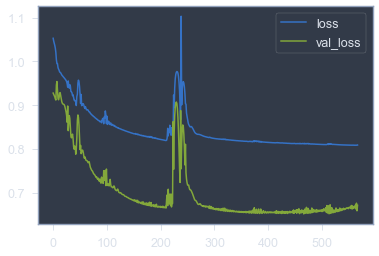

In [13]:
losses[['loss', 'val_loss']].plot()

In [14]:
passed_images = inputs[:13]

In [15]:
constructed_masks = model.predict(passed_images)

ORIGINAL IMAGE


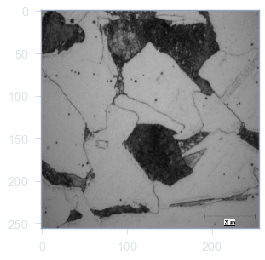

REAL MASK


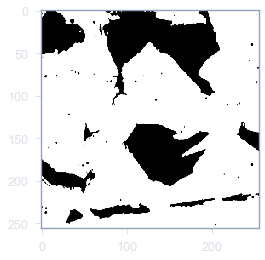

CONSTRUCTED MASK


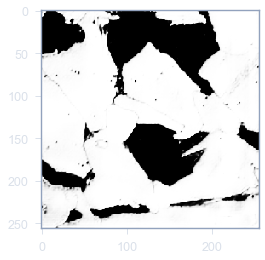

In [16]:
n=0
print('ORIGINAL IMAGE')
plt.imshow(np.squeeze(inputs[n]), cmap='gray')
plt.show()

print('REAL MASK')
plt.imshow(np.squeeze(masks[n]), cmap='gray')
plt.show()

print('CONSTRUCTED MASK')
plt.imshow(np.squeeze(constructed_masks[n]), cmap='gray')

In [17]:
test_path = 'C:\\Users\\kevin\\Desktop\\CMS\\Steel Image\\sample dataset\\23_H1_Long_1000x.jpg'
#edit to change image being evaluated

In [18]:
test =[]
img = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (256,256))
test.append(img)
    
test = np.array(test)
test = test/255
test = np.expand_dims(test, axis=-1)

In [19]:
test.shape

(1, 256, 256, 1)

ORIGINAL IMAGE


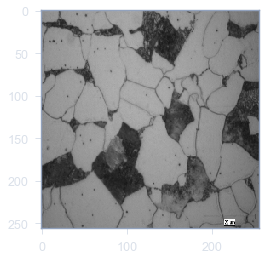

PREDICTED MASK


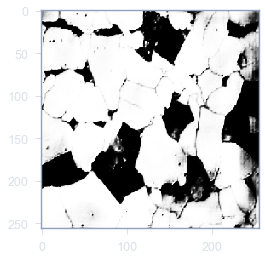

In [20]:
print('ORIGINAL IMAGE')
plt.imshow(np.squeeze(test[0]), cmap='gray')
plt.show()

print('PREDICTED MASK')
prediction = model.predict(test)
plt.imshow(np.squeeze(prediction[0]), cmap='gray')

In [21]:
prediction = np.squeeze(prediction[0]) * 255

In [22]:
prediction = prediction.astype('uint8')

In [23]:
prediction = cv2.resize(prediction, (1280, 960))
#cv2.imwrite('C:\\Users\\kevin\\Desktop\\CMS\\Steel Image\\constructed masks\\25_H3_Long_400x.jpg', prediction)

In [24]:
from tensorflow.keras.models import load_model #to load model

In [26]:
#model.save('C:\\Users\\kevin\\Desktop\\CMS\\Steel Image\\poisson.h5')

2